# CHD8 and IDDAM

<!-- Provide a brief overview of the syndrome and its genetic basis. Replace [Gene Name] and [Syndrome Name] with the specific gene and syndrome you are studying. -->

[Intellectual developmental disorder with autism and macrocephaly (IDDAM)](https://www.omim.org/entry/615032?search=intellectual%20developmental%20disorder%20with%20autism%20and%20macrocephaly&highlight=%28autism%7Cautistic%29%2Cdevelopmental%2Cdisorder%2Cintellectual%2Cmacrocephaly%2Cwith) is an autosomal dominant disease characterized by impaired intellectual development, a highly penetrant autism spectrum phenotype, and macrocephaly. Other common features include tall stature, gastrointestinal symptoms, distinct facial features, sleep problems, and attention problems [(An et al., 2020)](https://pubmed.ncbi.nlm.nih.gov/31980904/). The syndrome is caused by pathogenic variants in the [CHD8](https://omim.org/entry/610528?search=CHD8&highlight=chd8) gene.

The CHD8 gene is located on chromosome 14, and is part of a group of genes that all code for a chromodomain helicase DNA binding (CHD) protein. The CHD8 protein regulates gene expression through transcription factors and histone-modifying complexes. It specifically has been found to effect beta-catenin signalling and the Wnt-signalling pathway, which are both found to be essential in brain development [(Douzgou et al., 2019)](https://pubmed.ncbi.nlm.nih.gov/31001818/).


At least two previous publications have reported candidate genotype-phenotype correlations in IDDAM.

[Dingemans et al. (2022)](https://www.nature.com/articles/s41398-022-02189-1) stated that they were able to find a correlation between the severity of the phenotypes (as measured by a phenotype severity score termed a DeVries test) and missense variants on the CHD8 gene, specifically that those with a missense variant were significantly less affected than other individuals. 

[An et al. (2020)](https://pubmed.ncbi.nlm.nih.gov/31980904/) found that variants on the Helicase-C domain were significantly more likely to result in a higher severity (measured by total number of clinical features), lower verbal IQ, and a pattern of overgrowth (measured by weight, height, and head circumference). 

In this notebook, we use a modified version of the DeVries test [Dingemans et al. (2022)](https://www.nature.com/articles/s41398-022-02189-1) to test the above two hypotheses.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


## CHD8
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CHD8.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'CHD8'
mane_tx_id = 'NM_001170629.2'
mane_protein_id = "NP_001164100.1"
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.24'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 79/79 [00:00<00:00, 464.00 individuals/s]
Validated under permissive policy
No errors or warnings were found


## Define Configuration & Run Analysis

In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
35,Autism
29,Motor delay
29,Prominent supraorbital ridges
26,Delayed speech and language development
25,Macrocephaly
23,Tall stature
20,"Intellectual disability, mild"
20,Global developmental delay
18,Autistic behavior
17,Constipation


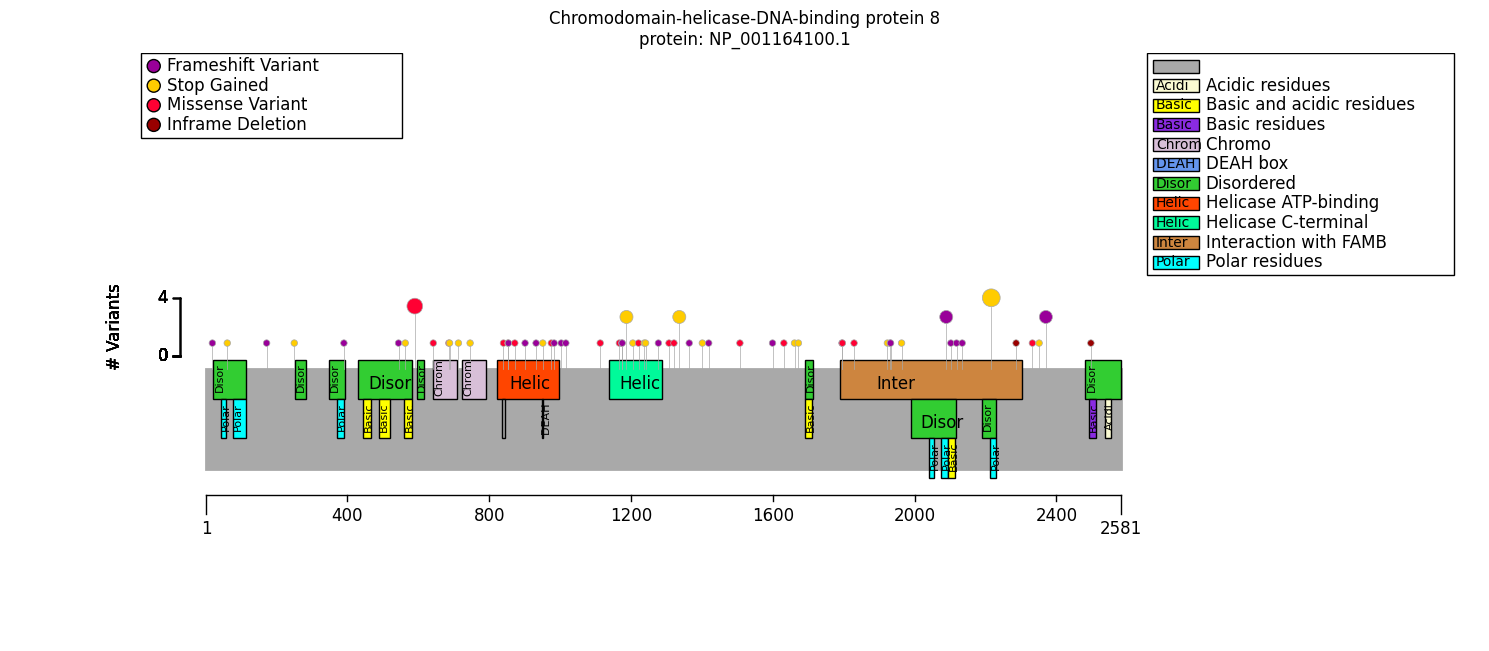

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

chd8_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
chd8_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
1,Disordered,Region,23 - 114,p.Ser62Ter
0,Polar residues,Compositional bias,44 - 58,
0,Polar residues,Compositional bias,77 - 114,
0,Disordered,Region,254 - 283,
1,Disordered,Region,350 - 392,p.Gln392ThrfsTer29
0,Polar residues,Compositional bias,371 - 389,
2,Disordered,Region,430 - 582,p.Arg564Ter; p.Lys545AsnfsTer47
0,Basic and acidic residues,Compositional bias,445 - 466,
0,Basic and acidic residues,Compositional bias,489 - 521,
1,Basic and acidic residues,Compositional bias,561 - 582,p.Arg564Ter


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest 
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_clf = monoallelic_classifier(a_predicate=is_missense,
                                        b_predicate=~is_missense,
                                        a_label="missense",
                                        b_label="other")

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
viewer = MtcStatsViewer()
viewer.process(missense_result)


Reason,Count
Skip terms if all counts are identical to counts for a child term,1
"Skipping ""general"" level terms",61
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),158


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo, missense_result)

Allele group,missense,other,Corrected p values,p values
Autistic behavior [HP:0000729],8/14 (57%),45/50 (90%),0.349273,0.009702
Autism [HP:0000717],4/12 (33%),31/44 (70%),0.518508,0.040111
Seizure [HP:0001250],0/11 (0%),10/32 (31%),0.518508,0.043209
Intellectual disability [HP:0001249],8/12 (67%),47/53 (89%),0.646539,0.077796
Tall stature [HP:0000098],2/7 (29%),21/32 (66%),0.646539,0.100507
Motor delay [HP:0001270],3/6 (50%),26/32 (81%),0.646539,0.131065
Reduced social responsiveness [HP:0012760],0/11 (0%),6/28 (21%),0.646539,0.157811
Pes planus [HP:0001763],4/9 (44%),5/30 (17%),0.646539,0.170223
Delayed speech and language development [HP:0000750],4/8 (50%),22/28 (79%),0.646539,0.179390
Attention deficit hyperactivity disorder [HP:0007018],0/14 (0%),8/47 (17%),0.646539,0.179594


In [10]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Autism [HP:0000717],7/19 (37%),28/37 (76%),0.131858,0.008006
Prominent supraorbital ridges [HP:0000336],5/13 (38%),24/29 (83%),0.131858,0.009356
"Intellectual disability, severe [HP:0010864]",0/22 (0%),10/41 (24%),0.131858,0.010988
Autistic behavior [HP:0000729],12/18 (67%),41/46 (89%),0.540987,0.060110
Stereotypic upper-extremity movements [HP:5200018],1/12 (8%),7/24 (29%),0.975380,0.223601
Tall stature [HP:0000098],3/8 (38%),20/31 (65%),0.975380,0.234878
Seizure [HP:0001250],1/13 (8%),9/30 (30%),0.975380,0.236797
"Intellectual disability, mild [HP:0001256]",9/22 (41%),11/42 (26%),0.975380,0.264484
Stereotypical hand wringing [HP:0012171],0/12 (0%),4/21 (19%),0.975380,0.271261
Midline hand movements [HP:5200009],0/11 (0%),4/21 (19%),0.975380,0.271969


In [11]:
from gpsea.analysis.pscore import DeVriesPhenotypeScorer, PhenotypeScoreAnalysis
from gpsea.analysis.pscore.stats import MannWhitneyStatistic

dv_scorer = DeVriesPhenotypeScorer(hpo)
mw_stats = MannWhitneyStatistic()

score_analysis = PhenotypeScoreAnalysis(mw_stats)
dv_missense_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, missense_clf, dv_scorer)
df = dv_missense_results.data
df.head()
mean_missense = df[df["genotype"] == 0]["phenotype"].mean()
mean_other = df[df["genotype"] == 1]["phenotype"].mean()
pval = dv_missense_results.pval
message = f"DeVries score: missense: mean = {mean_missense:.3f}, other, mean = {mean_other:.3f}; p-val= {pval:.3e}"
print(message)

DeVries score: missense: mean = 1.111, other, mean = 1.992; p-val= 8.985e-04


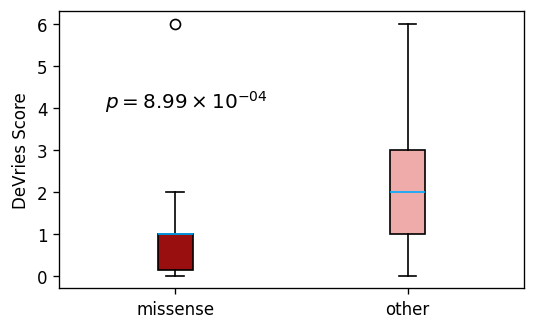

In [12]:
import matplotlib.pyplot as plt
dv_missense_fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
ax.set_ylabel("DeVries Score")
pval_text= f"p = {pval:.2e}".replace('e', '\\times 10^{').replace('+', '') + '}'
#ax.text(x=30, y=0.6, s=f"${s}$", fontsize=12)

plt.text(0.7, 4, f"${pval_text}$", fontsize=12)
dv_missense_results.plot_boxplots(ax=ax)

In [13]:
score_analysis = PhenotypeScoreAnalysis(mw_stats)
dv_mf_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, sex_classifier(), dv_scorer)
df = dv_mf_results.data
df.head()
mean_female = df[df["genotype"] == 0]["phenotype"].mean()
mean_male = df[df["genotype"] == 1]["phenotype"].mean()
pval_mf = dv_mf_results.pval
message = f"DeVries score: missense: mean (F) = {mean_female:.3f}, mean (M) = {mean_male:.3f}; p-val= {pval:.3e}"
print(message)

DeVries score: missense: mean (F) = 1.212, mean (M) = 2.075; p-val= 8.985e-04


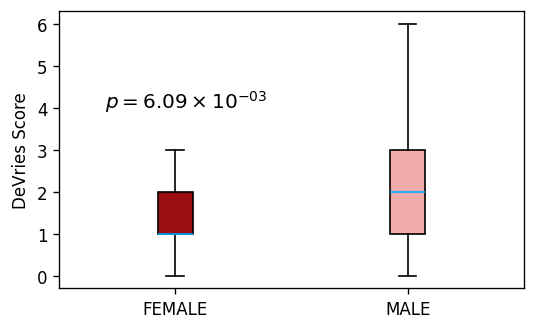

In [14]:
dv_mf_fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
ax.set_ylabel("DeVries Score")
pval_text= f"p = {pval_mf:.2e}".replace('e', '\\times 10^{').replace('+', '') + '}'

plt.text(0.7, 4, f"${pval_text}$", fontsize=12)
dv_mf_results.plot_boxplots(ax=ax)

# Summary

In [15]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=mf_result,
    )
)

m_results = (
    GPAnalysisResultSummary.from_multi(
        result=dv_missense_results
    ),
     GPAnalysisResultSummary.from_multi(
        result=dv_mf_results
    ), 
)

caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [16]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [17]:
summarizer.process_latex(report=report, protein_fig=chd8_fig, stats_fig=dv_missense_fig)

Figure saved to ../../supplement/img/CHD8_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/CHD8_stats-draft.pdf
Output to ../../supplement/tex/CHD8_summary_draft.tex
